<a href="https://colab.research.google.com/github/1kaiser/Jodhpur_ecostress_LST/blob/main/GRACE_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# part 1 [test2023 source](https://colab.research.google.com/github/1kaiser/test2023/blob/main/JPL_GRACE_and_GRACE_FO_Mascon_Ocean%2C_Ice%2C_and_Hydrology_Equivalent_Water_Height_Coastal_Resolution_Improvement_(CRI)_Filtered_Release_06_1.ipynb)

### pre reqiosite

In [ ]:
pip install podaac-data-subscriber

### creating credentials and saving the credentials as .netrc file

In [ ]:
!echo $HOME

/root


In [ ]:
%%writefile ~/.netrc
machine urs.earthdata.nasa.gov
    login kroy0001
    password /#j%kWrPA,8.HRe

Writing /root/.netrc


In [ ]:
!chmod 600 ~/.netrc


## **Run all of the above steps first**

### downloading of the GRACE FO data


```
--start-date 2002-04-04T00:00:00Z
--end-date 2002-10-11T00:00:00Z
-b="-180,-90,180,90"
```
**start date**

**end date**

**location**



In [ ]:
!podaac-data-downloader -c TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3 -d ./data --start-date 2002-04-04T00:00:00Z --end-date 2023-08-11T00:00:00Z -b="-180,-90,180,90"

[2023-09-12 16:30:06,910] {podaac_data_downloader.py:270} INFO - Found 1 total files to download
[2023-09-12 16:30:07,040] {podaac_data_downloader.py:305} INFO - 2023-09-12 16:30:07.040244 SKIPPED: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202306.GLO.RL06.1M.MSCNv03CRI.nc
[2023-09-12 16:30:07,040] {podaac_data_downloader.py:324} INFO - Downloaded Files: 0
[2023-09-12 16:30:07,040] {podaac_data_downloader.py:325} INFO - Failed Files:     0
[2023-09-12 16:30:07,040] {podaac_data_downloader.py:326} INFO - Skipped Files:    1
[2023-09-12 16:30:07,040] {podaac_data_downloader.py:334} INFO - END




In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.4 MB/s eta 0:00:00


**script for converting the nc file to monthly**

In [ ]:
# %%writefile write_singlemonth_geotif.py

#!/usr/bin/env python3


# This python script reads the GRACE mascon Level 3 data available in netcdf
# 'GRCTellus.JPL.*.RL06M.MSCNv02CRI.nc' and creates geotiff for each time step.
#
# Each grace timestep has two geotiffs, one for variable lwe_thickness and other for uncertainty.

# Users need to download the GRACE mascon netcdf file and set its location in the variable input_mascon_file (line #25) ;
# Additionally users need to specify in line # 26 the location of output geotiff.
# For any comments and feedback, please contact: podaac@jpl.nasa.gov

import datetime
from pathlib import Path

import numpy as np

from netCDF4 import Dataset, num2date
from osgeo import gdal, osr

# Data can be downloaded from here:
# https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2

# You will need an EarthData account to access the PO.DAAC drive.

# replace the NetCDF (nc) filename with current mascon netcdf name as it gets updated every month
# input_mascon_file = Path('PATH/TO/YOUR/INPUTFILE')
# output_geotiff_path = Path('/PATH/TO/YOUR/OUTPUTFILE')

input_mascon_file = Path('/content') / 'data' / 'GRCTellus.JPL.200204_202306.GLO.RL06.1M.MSCNv03CRI.nc'
output_geotiff_path = Path('/content') / 'output'
output_geotiff_path.mkdir(parents=True, exist_ok=True)

def gtiff_write(grid_data, data_res, output_geotiff_file, lat_bound_max, lon_bound_min):
    gdal_driver = gdal.GetDriverByName('GTiff')

    gtiff_name = str(output_geotiff_file)
    gtiff_out = gdal_driver.Create(gtiff_name, grid_data.shape[1], grid_data.shape[0], 1, gdal.GDT_Float32)

    out_geotransform = [lon_bound_min, data_res, 0, lat_bound_max, 0, -1*data_res]
    gtiff_out.SetGeoTransform(out_geotransform)

    out_wkt = osr.SpatialReference()
    out_wkt.ImportFromEPSG(4326)
    out_proj_wkt = out_wkt.ExportToWkt()
    gtiff_out.SetProjection(out_proj_wkt)

    gtiff_band_out = gtiff_out.GetRasterBand(1)
    gtiff_band_out.SetNoDataValue(-99999)
    gtiff_band_out.WriteArray(grid_data)

    gtiff_out = None
    gtiff_band_out = None


def gtiff_set_metadata(output_geotiff_file, ncdf, current_month_start_date, current_month_end_date, lon):
    attr_list = ncdf.ncattrs()
    attr_to_exclude = [
        'time_coverage_start',
        'time_coverage_end',
        'geospatial_lon_min',
        'geospatial_lon_max',
        'date_created',
        'months_missing'
    ]

    gtiff_name = str(output_geotiff_file)
    ras = gdal.Open(gtiff_name, gdal.GA_Update)

    for attr_name in attr_list:
        if attr_name not in attr_to_exclude:
            ras.SetMetadataItem(attr_name, str(ncdf.getncattr(attr_name)))

    ras.SetMetadataItem('time_coverage_start', current_month_start_date)
    ras.SetMetadataItem('time_coverage_end', current_month_end_date)
    ras.SetMetadataItem('geospatial_lon_min', str(np.min(lon)))
    ras.SetMetadataItem('geospatial_lon_max', str(np.max(lon)))

    now = datetime.datetime.now()
    ras.SetMetadataItem('date_created', now.strftime("%Y-%m-%dT%H:%M:%S"))

    ras = None

def main():
    # this segment opens the netcdf file and reads its variables.
    ncdf = Dataset(input_mascon_file, mode='r')

    input_time = ncdf.variables['time'][:]
    lat = ncdf.variables['lat'][:]
    lon = ncdf.variables['lon'][:]
    lon_bounds= ncdf.variables['lon_bounds'][:]
    lat_bounds= ncdf.variables['lat_bounds'][:]
    input_lwe_thickness = ncdf.variables['lwe_thickness'][:] #time lat lon
    input_uncertainty = ncdf.variables['uncertainty'][:]

    time_bounds = ncdf.variables['time_bounds'][:]
    dtime = num2date(time_bounds[:], ncdf.variables['time_bounds'].units)

    # initialize the arrays of same size as input dataset
    grid_lwe = input_lwe_thickness * 0
    grid_uncertainty = input_uncertainty * 0
    timesize = len(input_time)

    data_res  = abs(lon[2 ] - lon[1]) #resolution of dataset
    indexes_to_shift=int(360 / (2 * data_res)) # no of global longitude divided by degree resolution; /2 gives mid point around which shift is done.

    #detremine if grid is south to north then flip the array else not
    flip_lat = lat[0] < lat[-1]

    #detremine if longitudes starts at 0 and goes to n then circshift or roll the grid and longitude array
    shift_lon = np.max(lon) > 180

    #this loop arrange dataset in 90 to -90 latitude and -180 to 180 longitude orientation and writes monthly geotiffs;
    #works on array in the order: time*lat*lon ;
    if input_lwe_thickness.shape == (len(input_time), len(lat), len(lon)):
        for time_index in range(0,timesize):
            temp_lwe = input_lwe_thickness[time_index,:,:]
            temp_uncertainty = input_uncertainty[time_index,:,:]

            # mascon netcdf contains grid : 0 to 359 longitudes and -90 to 90 degree latitudes. following lines sets the grid as 180 to -180 longitude and 90 to -90 latitude to be written into geotif
            if flip_lat:
                temp_1a = np.flipud(temp_lwe)
                temp_1a_uncert = np.flipud(temp_uncertainty)
            else:
                temp_1a = temp_lwe
                temp_1a_uncert = temp_uncertainty

            if shift_lon:
                temp_1a = np.roll(temp_1a, indexes_to_shift, axis =1)
                temp_1a_uncert = np.roll(temp_1a_uncert, indexes_to_shift,axis =1)
                # arrange longitudes into -180 to 180 orientation
                lon[np.where(lon>180)] = lon[np.where(lon > 180)] - indexes_to_shift
                lon = np.roll(lon, indexes_to_shift, axis=0)
                lon_bounds[np.where(lon_bounds >= 180)] = lon_bounds[np.where(lon_bounds >= 180)] - indexes_to_shift
                lon_bounds = np.roll(lon_bounds, indexes_to_shift, axis=0)

            grid_lwe[time_index,:,:] = temp_1a
            grid_uncertainty[time_index,:,:] = temp_1a_uncert
            lat_bound_max = np.max(lat_bounds)
            lon_bound_min = np.min(lon_bounds)

            #determine the start and end period for each monthly timestep and use it in geotiff output filenames
            start_year = dtime[time_index,0].year
            end_year = dtime[time_index,1].year

            start_day_of_year = dtime[time_index,0].timetuple().tm_yday
            end_day_of_year = dtime[time_index,1].timetuple().tm_yday

            start_timestring = str(start_year)  + ("%03d" %(start_day_of_year,))
            end_timestring = str(end_year)  + ("%03d" %(end_day_of_year,))

            current_month_start_date = dtime[time_index,0].strftime("%Y-%m-%dT%H:%M:%S")
            current_month_end_date = dtime[time_index,1].strftime("%Y-%m-%dT%H:%M:%S")

            #generate lwe_thickness tiff file
            output_geotiff_file = 'mascon_lwe_thickness_' + start_timestring + '_' + end_timestring +  '.tif'
            output_geotiff_file = output_geotiff_path / output_geotiff_file

            # create geotiff
            gtiff_write(grid_lwe[time_index, :, :], data_res, output_geotiff_file, lat_bound_max, lon_bound_min)
            gtiff_set_metadata(output_geotiff_file, ncdf, current_month_start_date, current_month_end_date,lon)

            output_geotiff_uncert_file = 'mascon_uncertainty_' + start_timestring + '_' + end_timestring +  '.tif'
            output_geotiff_uncert_file = output_geotiff_path / output_geotiff_uncert_file

            # create geotiff
            gtiff_write(grid_uncertainty[time_index,:,:], data_res, output_geotiff_uncert_file, lat_bound_max, lon_bound_min)
            gtiff_set_metadata(output_geotiff_uncert_file, ncdf, current_month_start_date, current_month_end_date,lon)

    else:
        print('Array Dimensions Not in Desired Order; Time * Lat * Lon expected')

    ncdf.close()

if __name__ == '__main__':
    main()

In [ ]:
!zip /content/output.zip /content/output/*

  adding: content/output/mascon_lwe_thickness_2002094_2002120.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002122_2002138.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002213_2002243.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002244_2002273.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002274_2002304.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002305_2002334.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2002335_2002365.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2003001_2003031.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2003032_2003059.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2003060_2003090.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2003091_2003120.tif (deflated 96%)
  adding: content/output/mascon_lwe_thickness_2003121_2003141.tif (deflated 96%)
  adding: content/output/mas

# part 2 Visualizaition

### prerequisite

In [ ]:
!wget https://github.com/1kaiser/Jodhpur_ecostress_LST/releases/download/1/GRACE_global.zip
!unzip -o /content/GRACE_global.zip -d /content/files

In [ ]:
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/DEM.tif
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/SLOPE.tif
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/ASPECT.tif
!wget https://github.com/1kaiser/Jodhpur_ecostress_LST/releases/download/1/rajasthan_dem.tif

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
tif_path = "/content/rajasthan_dem.tif"
dataset = rasterio.open(tif_path)

# Read the raster data
raster_data = dataset.read(1, masked = True)
# Get the spatial extent
xmin, ymin, xmax, ymax = dataset.bounds

# Plot the raster using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='magma', extent=[xmin, xmax, ymin, ymax])

# Add a colorbar
plt.colorbar(shrink=0.7)

# Set the axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Raster Visualization')

# Display the plot
plt.show()

# Close the dataset
dataset.close()


using gdal

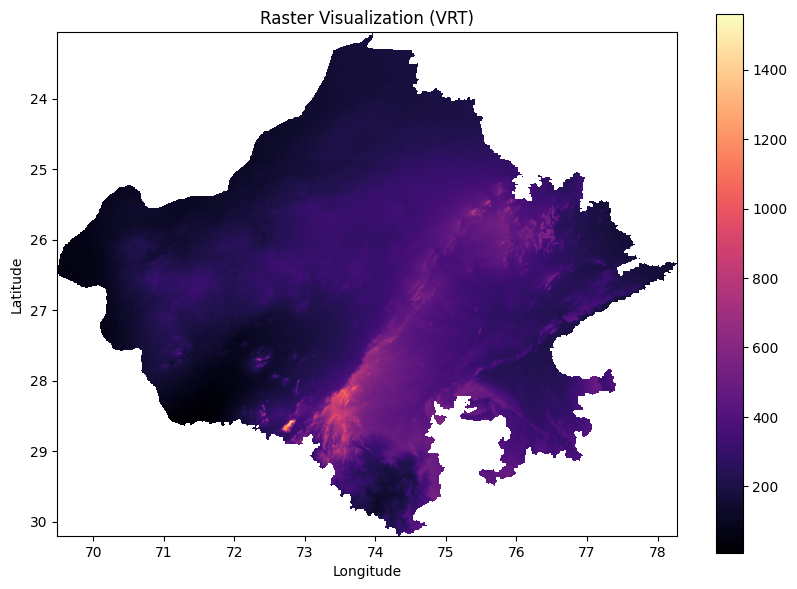

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# Open the TIFF file
tif_path = "/content/rajasthan_dem.tif"
dataset = gdal.Open(tif_path)

# Create a virtual raster (VRT) with a lower resolution
vrt_options = gdal.BuildVRTOptions(resampleAlg='average', xRes=0.01, yRes=0.01)
vrt_path = "/content/rajasthan_dem.vrt"
vrt_dataset = gdal.BuildVRT(vrt_path, dataset, options=vrt_options)

# Read the VRT raster data
vrt_raster_band = vrt_dataset.GetRasterBand(1)
vrt_raster_data = vrt_raster_band.ReadAsArray()

# Get the mask of the first band
mask = vrt_raster_band.GetMaskBand().ReadAsArray()
# Create a masked array from the raster data and mask
raster_masked = np.ma.masked_where(mask == 0, vrt_raster_data)


# Get the spatial extent of the VRT
vrt_geotransform = vrt_dataset.GetGeoTransform()
vrt_xmin, vrt_ymin = vrt_geotransform[0], vrt_geotransform[3]
vrt_xmax = vrt_xmin + vrt_geotransform[1] * vrt_dataset.RasterXSize
vrt_ymax = vrt_ymin + vrt_geotransform[5] * vrt_dataset.RasterYSize

# Plot the VRT raster using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(raster_masked, cmap='magma', extent=[vrt_xmin, vrt_xmax, vrt_ymin, vrt_ymax])

# Add a colorbar
plt.colorbar(shrink=0.7)

# Set the axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Raster Visualization (VRT)')

# Display the plot
plt.show()

# Close the VRT dataset
vrt_dataset = None


In [ ]:
input_tif_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"
dataset = gdal.Open(input_tif_path)

# Create a virtual raster (VRT) with a lower resolution
vrt_options1 = gdal.BuildVRTOptions(resampleAlg='average', xRes=0.01, yRes=0.01)
vrt_path1 = "/content/mascon.vrt"
vrt_dataset1 = gdal.BuildVRT(vrt_path1, dataset, options=vrt_options1)

In [ ]:
from osgeo import gdal
from osgeo import ogr

# Input GeoTIFF path
input_tif_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"

# Output GeoTIFF path for the clipped image
output_tif_path = "/content/clipped_mascon.tif"

# Open the TIFF file
tif_path = "/content/rajasthan_dem.tif"
dataset = gdal.Open(tif_path)

# Create a virtual raster (VRT) with a lower resolution
vrt_options = gdal.BuildVRTOptions(resampleAlg='average', xRes=0.01, yRes=0.01)
vrt_path = "/content/rajasthan_dem.vrt"
vrt_dataset = gdal.BuildVRT(vrt_path, dataset, options=vrt_options)

# Open the TIFF file
dataset = gdal.Open(input_tif_path)

# Create a virtual raster (VRT) with a lower resolution
vrt_options1 = gdal.BuildVRTOptions(resampleAlg='average', xRes=0.01, yRes=0.01)
vrt_path1 = "/content/mascon.vrt"
vrt_dataset1 = gdal.BuildVRT(vrt_path1, dataset, options=vrt_options1)


!gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A /content/rajasthan_dem.vrt \
    --A_band 1 \
    -B /content/mascon.vrt \
    --B_band 1 \
    --outfile=SmallerFileB.tif \
    --NoDataValue=0 \
    --calc="((A.astype(float)>1)**(B.astype(float))"

Error! Dimensions of file /content/mascon.vrt (36000, 18000) are different from other files (879, 714).  Cannot proceed


In [ ]:
from osgeo import gdal
from osgeo import ogr
# Define paths to the input rasters
input_raster_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"
clip_extent_raster_path = "/content/rajasthan_dem.tif"
output_clipped_raster_path = "/content/output_clipped_raster.tif"  # Include full path

# Open the input raster and clip extent raster
input_raster = gdal.Open(input_raster_path)
clip_extent_raster = gdal.Open(clip_extent_raster_path)

# Get the extent and geotransform of the clip extent raster
clip_extent_geotransform = clip_extent_raster.GetGeoTransform()
clip_extent_xmin = clip_extent_geotransform[0]
clip_extent_ymin = clip_extent_geotransform[3]
clip_extent_xmax = clip_extent_xmin + clip_extent_geotransform[1] * clip_extent_raster.RasterXSize
clip_extent_ymax = clip_extent_ymin + clip_extent_geotransform[5] * clip_extent_raster.RasterYSize

# Set the warp options
warp_options = gdal.WarpOptions(
    format="GTiff",
    cutlineDSName=clip_extent_raster_path,  # Clip extent raster
    cutlineWhere="POLYGON",  # Modify this if needed (e.g., "ID=1")
    cropToCutline=True,  # Crop the output to the extent of the cutline
    outputBounds=(clip_extent_xmin, clip_extent_ymin, clip_extent_xmax, clip_extent_ymax),  # Clip extent
)

# Perform the clipping operation
clipped_raster = gdal.Warp(output_clipped_raster_path, input_raster, options=warp_options)

# Close the datasets
clipped_raster = None
input_raster = None
clip_extent_raster = None

print(f"Raster clipping completed. Clipped raster saved to {output_clipped_raster_path}")


Raster clipping completed. Clipped raster saved to /content/output_clipped_raster.tif


rasterio **version**

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os

def view_tiff_file(tif_path):
    # Extract day of year from the file name
    year = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][0:4]
    doy = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][4:7]

    dataset = gdal.Open(tif_path)

    # Read the raster data
    raster_data = dataset.GetRasterBand(1).ReadAsArray()


    tif_path = "/content/rajasthan_dem.tif"
    dataset = gdal.Open(tif_path)

    # Create a virtual raster (VRT) with a lower resolution
    vrt_options = gdal.BuildVRTOptions(resampleAlg='average', xRes=0.01, yRes=0.01)
    vrt_path = "/content/rajasthan_dem.vrt"
    vrt_dataset = gdal.BuildVRT(vrt_path, dataset, options=vrt_options)

    # Read the VRT raster data
    vrt_raster_band = vrt_dataset.GetRasterBand(1)
    vrt_raster_data = vrt_raster_band.ReadAsArray()

    # Get the mask of the first band
    mask = vrt_raster_band.GetMaskBand().ReadAsArray()
    # Create a masked array from the raster data and mask
    raster_masked = np.ma.masked_where(mask == 0, vrt_raster_data)


    # Get the spatial extent of the VRT
    vrt_geotransform = vrt_dataset.GetGeoTransform()
    vrt_xmin, vrt_ymin = vrt_geotransform[0], vrt_geotransform[3]
    vrt_xmax = vrt_xmin + vrt_geotransform[1] * vrt_dataset.RasterXSize
    vrt_ymax = vrt_ymin + vrt_geotransform[5] * vrt_dataset.RasterYSize

    # Plot the VRT raster using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(raster_data, cmap='magma', extent=[vrt_xmin, vrt_xmax, vrt_ymin, vrt_ymax])
    plt.colorbar(shrink=0.7)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Day of Year: {year} - {doy}')

    # Set the output path based on the doy
    output_path = f"/content/{year}{doy}.png"

    # Save the plot as PNG
    plt.savefig(output_path, dpi=300)

    plt.close()

# Example usage
tif_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"
view_tiff_file(tif_path)

# part 2

In [ ]:
image_dir = r'/content/files/content/output'  #/mascon_lwe_thickness_2002094_2002120.tif

#############################################################################
prefix = "mascon_lwe_thickness_"
bandend = ["LST", "PWV", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix

temp_dir = r'/content/'
import os

imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)

                    #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....

imgs_path_b1 = [os.path.join(image_dir, i) for i in imgs_list_b1 if i != 'outputs']
print(len(imgs_path_b1))

222


In [ ]:
tif_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"
year = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][0:4]
doy = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][4:7]
print(year,doy)

2002 094


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os

def view_tiff_file(tif_path):
    # Open the TIFF file
    dataset = rasterio.open(tif_path)

    # Read the raster data
    raster_data = dataset.read(1, masked=True)

    # Get the spatial extent
    dataset1 = rasterio.open("/content/rajasthan_dem.tif")
    xmin, ymin, xmax, ymax = dataset1.bounds

    # Extract day of year from the file name
    year = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][0:4]
    doy = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][4:7]

    # Plot the raster using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(raster_data, cmap='magma', extent=[xmin, xmax, ymin, ymax])
    plt.colorbar(shrink=0.7)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Day of Year: {year} - {doy}')

    # Set the output path based on the doy
    output_path = f"/content/{year}{doy}.png"

    # Save the plot as PNG
    plt.savefig(output_path, dpi=300)

    # Close the dataset
    dataset.close()
    plt.close()

# Example usage
tif_path = "/content/files/content/output/mascon_lwe_thickness_2002094_2002120.tif"
view_tiff_file(tif_path)


In [ ]:
for file_name in imgs_list_b1:
    file_name = '/content/files/content/output/' + file_name
    view_tiff_file(file_name)

In [ ]:
#####################################create video 1
!ffmpeg \
-framerate 10 \
-pattern_type glob \
-i '/content/*.png' \
/content/files/input0.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

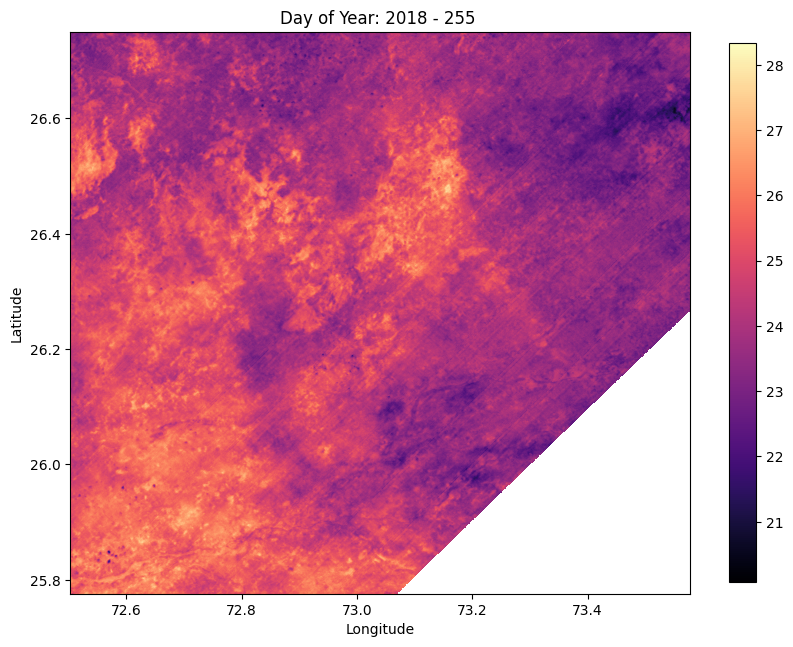

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os

def view_tiff_file(tif_path):
    # Open the TIFF file
    dataset = rasterio.open(tif_path)

    # Read the raster data
    raster_data = dataset.read(1, masked=True) * 0.02 - 273.15

    # Get the spatial extent
    xmin, ymin, xmax, ymax = dataset.bounds

    # Extract day of year from the file name
    year = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][3:7]
    doy = os.path.splitext(os.path.basename(tif_path))[0].split('_')[-2][7:10]
    # print(year,doy)

    # Plot the raster using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(raster_data, cmap='magma', extent=[xmin, xmax, ymin, ymax])

    # Add a colorbar
    plt.colorbar(shrink=0.7)

    # Set the axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Set the title
    plt.title(f'Day of Year: {year} - {doy} ')

    # Set the output path based on the doy
    output_path = f"/content/{year}{doy}.png"

    # Save the plot as PNG
    plt.savefig(output_path, dpi=300)

    # # Display the plot
    plt.show()

    # Close the dataset
    dataset.close()

# Example usage
tif_path = "/content/files/content/testfiles/ECO2LSTE.001_SDS_LST_doy2018255023709_aid0001.tif"
view_tiff_file(tif_path)


In [ ]:
from osgeo import gdal, osr

def transform_and_reshape_raster(raster_file, dem_file, output_file):
    # Open the DEM file
    dem_dataset = gdal.Open(dem_file, gdal.GA_ReadOnly)
    if dem_dataset is None:
        print("Failed to open the DEM file.")
        return

    # Get the DEM projection and geotransform information
    dem_projection = dem_dataset.GetProjection()
    dem_geotransform = dem_dataset.GetGeoTransform()

    # Open the raster file
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    if raster_dataset is None:
        print("Failed to open the raster file.")
        return

    # Get the raster projection and geotransform information
    raster_projection = raster_dataset.GetProjection()
    raster_geotransform = raster_dataset.GetGeoTransform()

    # Create a new dataset for the output file
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

    # Set the output dataset's projection and geotransform
    output_dataset.SetProjection(dem_projection)
    output_dataset.SetGeoTransform(dem_geotransform)

    # Reproject and reshape the raster
    gdal.ReprojectImage(raster_dataset, output_dataset, raster_projection, dem_projection, gdal.GRA_NearestNeighbour)

    # Close the datasets
    dem_dataset = None
    raster_dataset = None
    output_dataset = None

    print("Raster transformation and reshaping completed.")

import rasterio
import matplotlib.pyplot as plt

def plot_dem_raster(file_path):
    # Open the DEM raster file
    dem_in = rasterio.open(file_path)
    dem_data = dem_in.read(1, masked=True)
    left, bottom, right, top = dem_in.bounds
    fig, ax = plt.subplots()

    # Show the raster on the plot
    im = ax.imshow(dem_data , extent=[left, right, bottom, top])

    # Add a legend
    cbar = plt.colorbar(im, ax=ax, shrink=0.5)

    # Set the label for the legend
    cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

    # Show the plot
    plt.show()

import rasterio
import numpy as np
import numpy.ma as ma

def calculate_raster_statistics(file_path):
    # Open the raster file
    src = rasterio.open(file_path)
    data = src.read(1, masked=True)

    # Calculate the statistics of the data
    # min_val = np.min(data)
    # max_val = np.max(data)
    mean_val = np.mean(data)
    # median_val = ma.median(data)  # Use numpy.ma.median() for masked arrays
    # std_val = np.std(data)

    # Calculate the number of pixels
    num_pixels = np.sum(~data.mask)

    # Get the pixel size
    x_resolution = src.res[0]
    y_resolution = src.res[1]

    return [ mean_val, num_pixels * x_resolution * y_resolution / 1000000 ]

def extract_doy_year(fname):
    year_start_index = fname.find('doy') + 3
    year_end_index = year_start_index + 4
    doy_start_index = year_end_index
    doy_end_index = doy_start_index + 3

    year = int(fname[year_start_index:year_end_index])
    doy = int(fname[doy_start_index:doy_end_index])

    return doy, year

pathb1 = imgs_list_b1[10]
pathb2 = pathb1.replace(expression_b1, expression_b2)
temp_dir = f'/content/'

file_outputs = []  # List to store outputs for each file

# Loop through each file
for file_name in imgs_list_b1:
    file_name = '/content/files/' + file_name
    # Run the function 7 times for the current file
    outputs = []
    transform_and_reshape_raster(file_name, str(temp_dir)+'DEM.tif', str(temp_dir)+'output_reprojected.tif')

    E_difference = 500
    last_num = int(7000/E_difference)
    for i in range(1, last_num + 1):
        !gdal_calc.py \
            --overwrite \
            --type=Float32 \
            -A {temp_dir}DEM.tif \
            --A_band 1 \
            -B {temp_dir}output_reprojected.tif \
            --B_band 1 \
            --outfile=SmallerFileB"{str(i)}".tif \
            --NoDataValue=0 \
            --calc="((A.astype(float)>{E_difference*(i-1)})*(A.astype(float)<={E_difference*i})*1)*(B.astype(float))"
        print()
        # plot_dem_raster('SmallerFileB'+str(i)+'.tif')
        output = calculate_raster_statistics('SmallerFileB'+str(i)+'.tif')
        outputs.append(output)

    # doy, year = extract_doy_year(file_name)
    # Add the file name and outputs to the file_outputs list
    file_outputs.append([file_name, outputs])

    from google.colab import output
    output.clear()

    # Save the file outputs as a text file
    output_file = "file_outputs.txt"  # Specify the file name or path as needed
    with open(output_file, 'w') as f:
        for file_output in file_outputs:
            file_name = file_output[0]
            outputs = file_output[1]

            f.write(f"{file_name},")
            f.write(", ".join(str(output) for output in outputs) + "\n")





In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the DEM raster file
dem_in = rasterio.open('/content/DEM.tif')
dem_data = dem_in.read(1, masked=True)

# Set the range values to select
min_range = 2000
max_range = 3000

# Apply the range condition to the DEM data
dem_data_range = np.where((dem_data >= min_range) & (dem_data <= max_range), dem_data, np.nan)

# Open the raster file
src = rasterio.open(imgs_path_b1[4])
data = src.read(1, masked=True)

left, bottom, right, top = src.bounds

# Calculate the statistics of the data
min_val = np.min(data)
max_val = np.max(data)
mean_val = np.mean(data)
std_val = np.std(data)

# Create a plot
fig, ax = plt.subplots()

# Show the raster on the plot
ax.imshow(dem_data_range, extent=[left, right, bottom, top])
# im = ax.imshow(data, extent=[left, right, bottom, top])

# Add a legend
cbar = plt.colorbar(im, ax=ax, shrink=0.5)

# Set the label for the legend
cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

# Show the plot
plt.show()

# Print the statistics
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)


# part 2 parallel execution

In [ ]:
image_dir = r'/content/files'

#############################################################################
prefix = "ECO2LSTE.001_SDS_"
bandend = ["LST", "PWV", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+bandend[0]
expression_b2 = prefix+bandend[1]

temp_dir = r'/content/'
import os

imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)

                    #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....

imgs_path_b1 = [os.path.join(image_dir, i) for i in imgs_list_b1 if i != 'outputs']
print(len(imgs_path_b1))

from osgeo import gdal, osr

def transform_and_reshape_raster(raster_file, dem_file, output_file):
    # Open the DEM file
    dem_dataset = gdal.Open(dem_file, gdal.GA_ReadOnly)
    if dem_dataset is None:
        print("Failed to open the DEM file.")
        return

    # Get the DEM projection and geotransform information
    dem_projection = dem_dataset.GetProjection()
    dem_geotransform = dem_dataset.GetGeoTransform()

    # Open the raster file
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    if raster_dataset is None:
        print("Failed to open the raster file.")
        return

    # Get the raster projection and geotransform information
    raster_projection = raster_dataset.GetProjection()
    raster_geotransform = raster_dataset.GetGeoTransform()

    # Create a new dataset for the output file
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

    # Set the output dataset's projection and geotransform
    output_dataset.SetProjection(dem_projection)
    output_dataset.SetGeoTransform(dem_geotransform)

    # Reproject and reshape the raster
    gdal.ReprojectImage(raster_dataset, output_dataset, raster_projection, dem_projection, gdal.GRA_NearestNeighbour)

    # Close the datasets
    dem_dataset = None
    raster_dataset = None
    output_dataset = None

    print("Raster transformation and reshaping completed.")

import rasterio
import matplotlib.pyplot as plt

def plot_dem_raster(file_path):
    # Open the DEM raster file
    dem_in = rasterio.open(file_path)
    dem_data = dem_in.read(1, masked=True) * 0.02 - 273.15
    left, bottom, right, top = dem_in.bounds
    fig, ax = plt.subplots()

    # Show the raster on the plot
    im = ax.imshow(dem_data , extent=[left, right, bottom, top])

    # Add a legend
    cbar = plt.colorbar(im, ax=ax, shrink=0.5)

    # Set the label for the legend
    cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

    # Show the plot
    plt.show()

import rasterio
import numpy as np
import numpy.ma as ma

def calculate_raster_statistics(file_path):
    # Open the raster file
    src = rasterio.open(file_path)
    data = src.read(1, masked=True) * 0.02 - 273.15

    # Calculate the statistics of the data
    # min_val = np.min(data)
    # max_val = np.max(data)
    mean_val = np.mean(data)
    # median_val = ma.median(data)  # Use numpy.ma.median() for masked arrays
    # std_val = np.std(data)

    # Calculate the number of pixels
    num_pixels = np.sum(~data.mask)

    # Get the pixel size
    x_resolution = src.res[0]
    y_resolution = src.res[1]

    return [ mean_val, num_pixels * x_resolution * y_resolution / 1000000 ]

def extract_doy_year(fname):
    year_start_index = fname.find('doy') + 3
    year_end_index = year_start_index + 4
    doy_start_index = year_end_index
    doy_end_index = doy_start_index + 3

    year = int(fname[year_start_index:year_end_index])
    doy = int(fname[doy_start_index:doy_end_index])

    return doy, year


temp_dir = f'/content/'

file_outputs = []  # List to store outputs for each file
import multiprocessing
import os
from osgeo import gdal

def process_file(args):
    from google.colab import output
    output.clear()

    file_name, process_num = args
    !mkdir {process_num}
    outputs = []
    transform_and_reshape_raster(str(temp_dir+'files/')+file_name, str(temp_dir)+'DEM.tif', str(temp_dir)+str(process_num)+'/output_reprojected.tif')

    E_difference = 500
    last_num = int(7000/E_difference)
    for i in range(1, last_num + 1):
        !gdal_calc.py \
            --overwrite \
            --type=Float32 \
            -A {temp_dir}DEM.tif \
            --A_band 1 \
            -B {temp_dir}{process_num}/output_reprojected.tif \
            --B_band 1 \
            --outfile={process_num}/SmallerFileB"{str(i)}".tif \
            --NoDataValue=0 \
            --calc="((A.astype(float)>{E_difference*(i-1)})*(A.astype(float)<={E_difference*i})*1)*(B.astype(float))"
        print()
        # plot_dem_raster('SmallerFileB'+str(i)+'.tif')
        output = calculate_raster_statistics(str(process_num)+'/SmallerFileB'+str(i)+'.tif')
        outputs.append(output)
    !rm -r {process_num}
    return [file_name, process_num, outputs]

if __name__ == '__main__':
    # Create a multiprocessing Pool with the maximum number of processes
    pool = multiprocessing.Pool(processes=4)

    file_outputs = []
    results = pool.map(process_file, [(file_name, process_num) for process_num, file_name in enumerate(imgs_list_b1)])

    # Close the pool to prevent any more tasks from being submitted
    pool.close()

    # Get the results from the completed processes
    for result in results:
        file_outputs.append(result)

    # Save the file outputs as a text file
    output_file = "file_outputs.txt"  # Specify the file name or path as needed
    with open(output_file, 'w') as f:
        for file_output in file_outputs:
            file_name = file_output[0]
            process_num = file_output[1]
            outputs = file_output[2]

            f.write(f"{file_name},{process_num},")
            f.write(", ".join(str(output) for output in outputs) + "\n")


